In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import queue
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()


In [5]:
def slice_parameters(param, num_slices=4):
    return torch.chunk(param.grad, chunks=num_slices, dim=0)


In [ ]:
priority_mapping = {layer_name.split('.')[0]: i+1 for i, (layer_name, param) in enumerate(model.named_parameters())}
priority_queue = queue.PriorityQueue()
slices_dict = {}
priority_log = []  

In [ ]:
training_losses = []
validation_accuracies = []

for epoch in range(20):  
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()

        # Step 1: Slice gradients and assign priorities
        for layer_name, param in model.named_parameters():
            if param.grad is not None:
                layer_prefix = layer_name.split('.')[0]
                priority = priority_mapping.get(layer_prefix, 1)
                slices = slice_parameters(param, num_slices=4)
                
                for i, slice_grad in enumerate(slices):
                    slice_key = f"{layer_prefix}_slice_{i}"
                    slices_dict[slice_key] = slice_grad
                    priority_queue.put((priority, slice_key))

        # Step 2: Process slices in priority order
        while not priority_queue.empty():
            priority, slice_key = priority_queue.get()
            slice_grad = slices_dict[slice_key]
            priority_log.append(priority)

        # Step 3: Update weights
        optimizer.step()
        running_loss += loss.item()

    training_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {validation_accuracy:.2f}%")


Epoch 1, Loss: 1.8086, Accuracy: 47.74%
Epoch 2, Loss: 1.1263, Accuracy: 67.06%
Epoch 3, Loss: 0.8313, Accuracy: 71.14%
Epoch 4, Loss: 0.6564, Accuracy: 76.32%
Epoch 5, Loss: 0.5526, Accuracy: 76.93%
Epoch 6, Loss: 0.4453, Accuracy: 78.89%
Epoch 7, Loss: 0.3390, Accuracy: 79.11%
Epoch 8, Loss: 0.2699, Accuracy: 79.49%
Epoch 9, Loss: 0.2114, Accuracy: 79.66%
Epoch 10, Loss: 0.1609, Accuracy: 80.23%
Epoch 11, Loss: 0.1291, Accuracy: 80.85%
Epoch 12, Loss: 0.1057, Accuracy: 81.32%
Epoch 13, Loss: 0.0961, Accuracy: 81.41%
Epoch 14, Loss: 0.0723, Accuracy: 81.61%
Epoch 15, Loss: 0.0649, Accuracy: 82.03%
Epoch 16, Loss: 0.0520, Accuracy: 80.81%
Epoch 17, Loss: 0.0503, Accuracy: 82.55%
Epoch 18, Loss: 0.0441, Accuracy: 82.03%
Epoch 19, Loss: 0.0441, Accuracy: 80.89%
Epoch 20, Loss: 0.0365, Accuracy: 82.70%


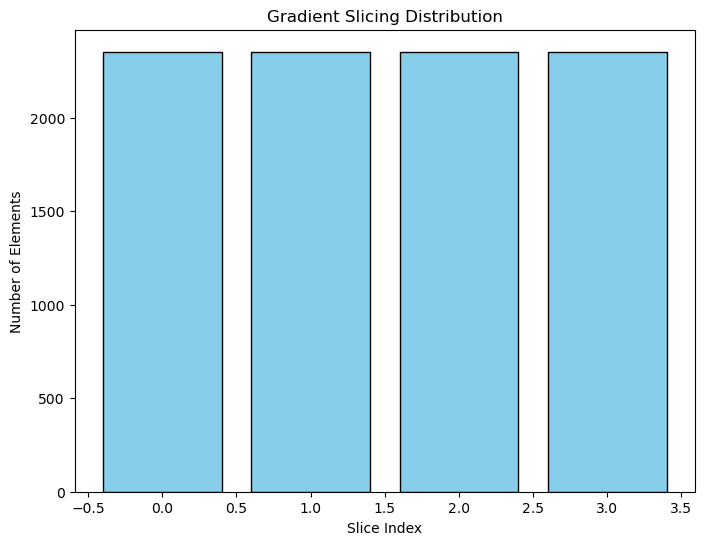

In [ ]:
def visualize_gradient_slices(param, num_slices=4):
    slices = torch.chunk(param.grad, chunks=num_slices, dim=0)
    slice_sizes = [slice_grad.numel() for slice_grad in slices]

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(slice_sizes)), slice_sizes, color='skyblue', edgecolor='black')
    plt.xlabel("Slice Index")
    plt.ylabel("Number of Elements")
    plt.title("Gradient Slicing Distribution")
    plt.show()

param = next(iter(model.parameters()))
visualize_gradient_slices(param, num_slices=4)

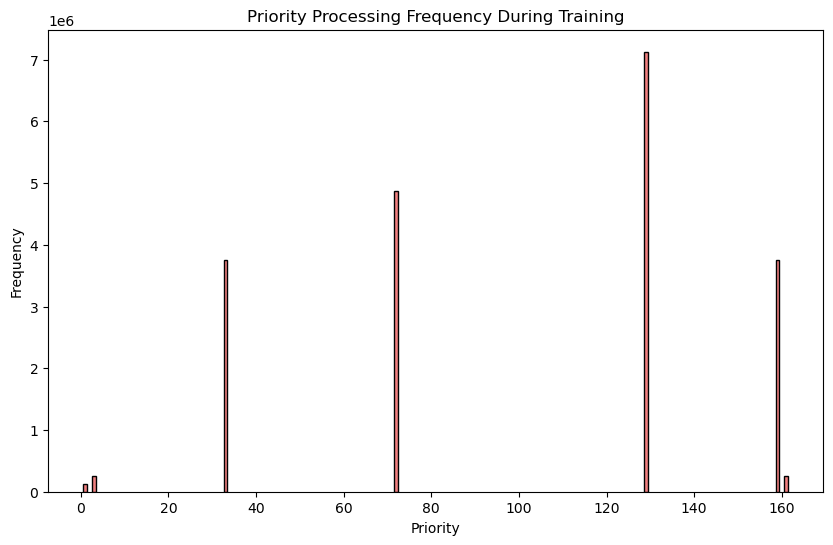

In [9]:
def visualize_processing_and_priority(priority_log):
    priority_counts = Counter(priority_log)
    priorities, counts = zip(*sorted(priority_counts.items()))

    plt.figure(figsize=(10, 6))
    plt.bar(priorities, counts, color='lightcoral', edgecolor='black')
    plt.xlabel("Priority")
    plt.ylabel("Frequency")
    plt.title("Priority Processing Frequency During Training")
    plt.show()

visualize_processing_and_priority(priority_log)

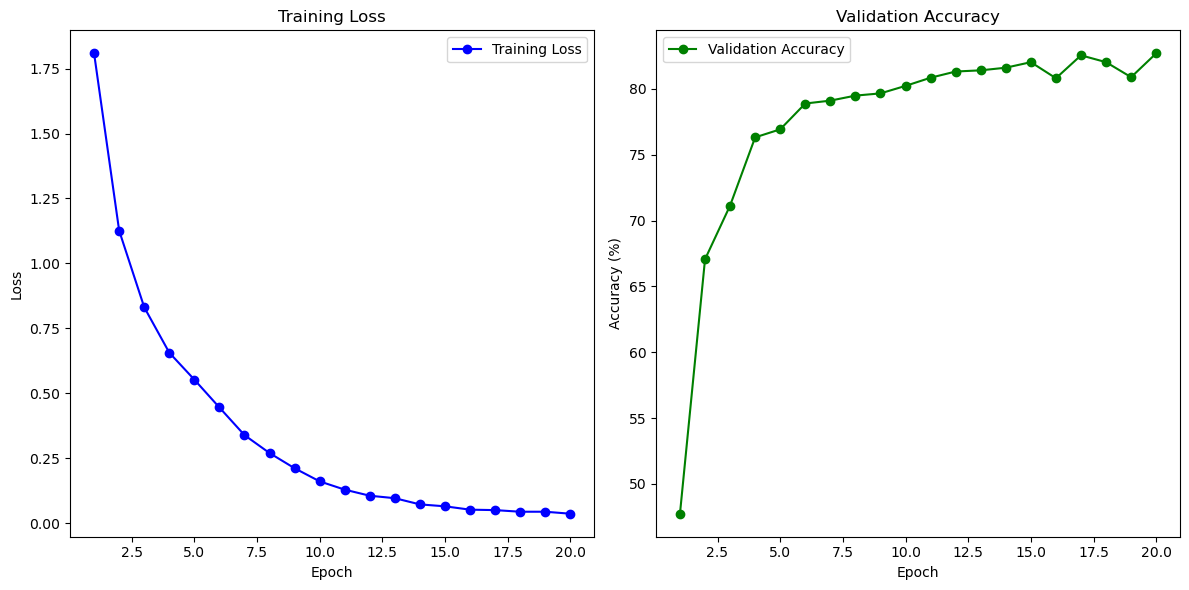

In [10]:
epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(12, 6))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, marker='o', label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracies, marker='o', label="Validation Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


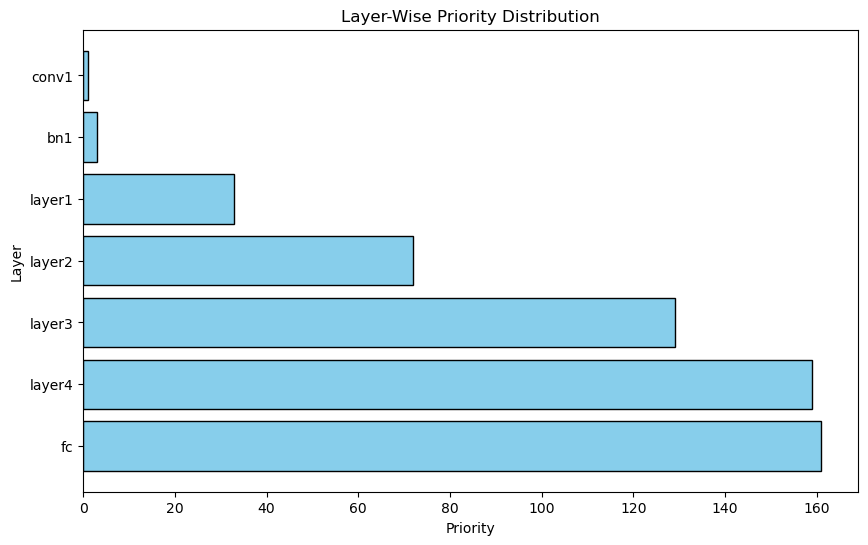

In [11]:
def visualize_layer_priorities(priority_mapping):
    layers, priorities = zip(*priority_mapping.items())

    plt.figure(figsize=(10, 6))
    plt.barh(layers, priorities, color='skyblue', edgecolor='black')
    plt.xlabel("Priority")
    plt.ylabel("Layer")
    plt.title("Layer-Wise Priority Distribution")
    plt.gca().invert_yaxis()  # To display the top-priority layers at the top
    plt.show()

# Example usage
visualize_layer_priorities(priority_mapping)


In [13]:
gpu_memory_usage = []

for inputs, targets in train_loader:
    gpu_memory = torch.cuda.memory_allocated(device) / (1024 ** 3)  # Convert to GB
    gpu_memory_usage.append(gpu_memory)


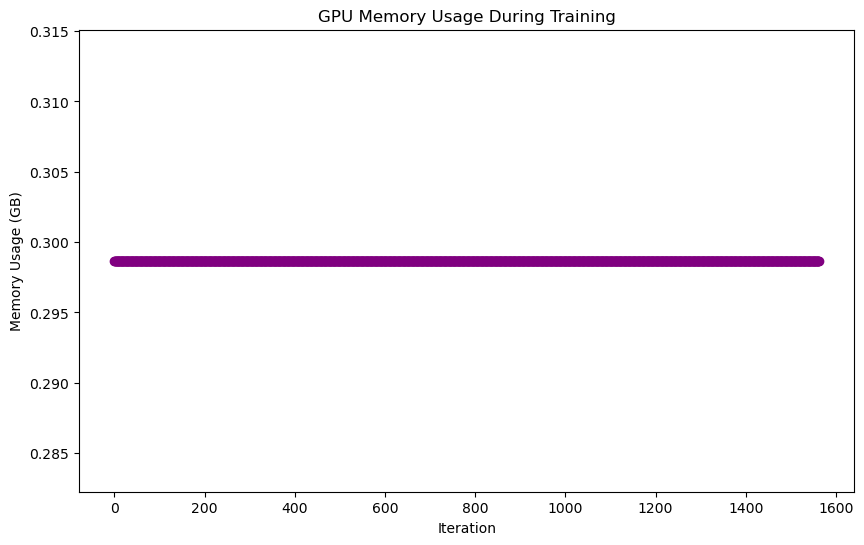

In [14]:
def visualize_gpu_memory(gpu_memory_usage):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(gpu_memory_usage)), gpu_memory_usage, marker='o', linestyle='-', color='purple')
    plt.xlabel("Iteration")
    plt.ylabel("Memory Usage (GB)")
    plt.title("GPU Memory Usage During Training")
    plt.show()

# Example usage
visualize_gpu_memory(gpu_memory_usage)


In [15]:
slice_processing_times = []
import time

while not priority_queue.empty():
    start_time = time.time()  # Start timing
    priority, slice_key = priority_queue.get()
    slice_grad = slices_dict[slice_key]
    priority_log.append(priority)  # Log the priority
    elapsed_time = time.time() - start_time  # Calculate processing time
    slice_processing_times.append((priority, elapsed_time))  # Log the time
    print(f"Processed slice {slice_key} with priority {priority} in {elapsed_time:.4f} seconds")


In [16]:
if len(slice_processing_times) == 0:
    print("No slice processing times were logged. Check if the priority queue was populated and processed correctly.")
else:
    print(f"Logged {len(slice_processing_times)} slice processing times. Example: {slice_processing_times[:5]}")


No slice processing times were logged. Check if the priority queue was populated and processed correctly.


In [ ]:
for layer_name, param in model.named_parameters():
    if param.grad is not None:
        slices = slice_parameters(param, num_slices=4)  
        for i, slice_grad in enumerate(slices):
            slice_key = f"{layer_name}_slice_{i}"
            slices_dict[slice_key] = slice_grad
            priority_queue.put((priority_mapping[layer_name.split('.')[0]], slice_key))


In [ ]:
def visualize_processing_times(slice_processing_times):
    if len(slice_processing_times) == 0:
        print("No processing times to visualize.")
        return

    # Unpack priorities and times
    priorities, times = zip(*slice_processing_times)

    # scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(priorities, times, alpha=0.6, color='orange')
    plt.xlabel("Priority")
    plt.ylabel("Processing Time (seconds)")
    plt.title("Slice Processing Time by Priority")
    plt.show()

visualize_processing_times(slice_processing_times)


No processing times to visualize.


In [19]:
high_priority_losses = []

for layer_name, param in model.named_parameters():
    if priority_mapping.get(layer_name.split('.')[0], 1) == 1:  # Example: High priority is 1
        if param.grad is not None:
            high_priority_losses.append(loss.item())  # Log loss


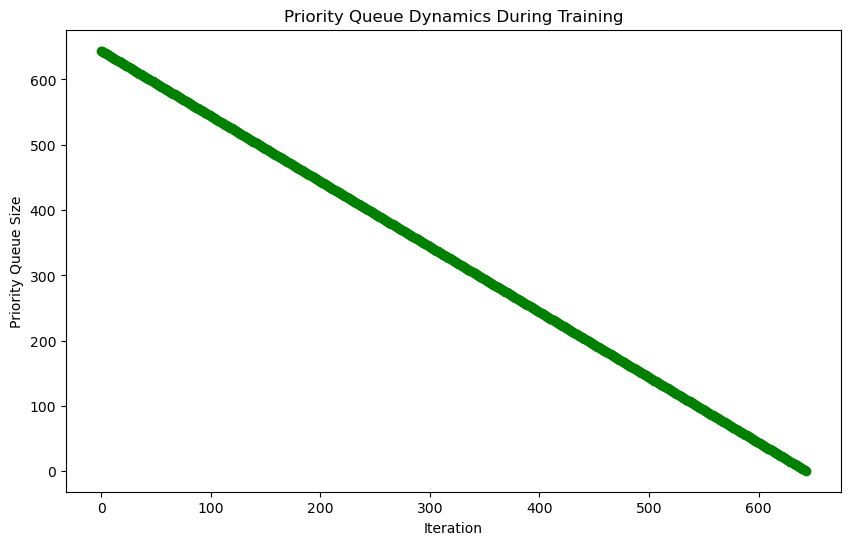

In [22]:
def visualize_priority_queue_sizes(priority_queue_sizes):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(priority_queue_sizes)), priority_queue_sizes, marker='o', linestyle='-', color='green')
    plt.xlabel("Iteration")
    plt.ylabel("Priority Queue Size")
    plt.title("Priority Queue Dynamics During Training")
    plt.show()

# Example usage
visualize_priority_queue_sizes(priority_queue_sizes)


In [23]:
gradient_norms = []

for layer_name, param in model.named_parameters():
    if param.grad is not None:
        grad_norm = param.grad.norm().item()
        gradient_norms.append((layer_name, grad_norm))


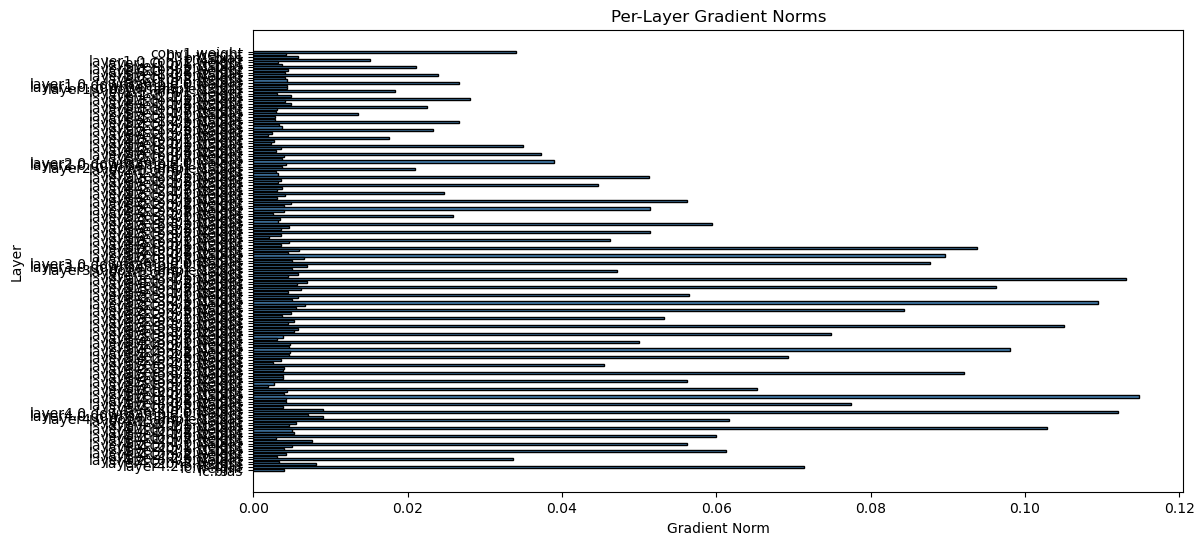

In [24]:
def visualize_gradient_norms(gradient_norms):
    layers, norms = zip(*gradient_norms)

    plt.figure(figsize=(12, 6))
    plt.barh(layers, norms, color='steelblue', edgecolor='black')
    plt.xlabel("Gradient Norm")
    plt.ylabel("Layer")
    plt.title("Per-Layer Gradient Norms")
    plt.gca().invert_yaxis()  # Top-to-bottom order
    plt.show()

# Example usage
visualize_gradient_norms(gradient_norms)


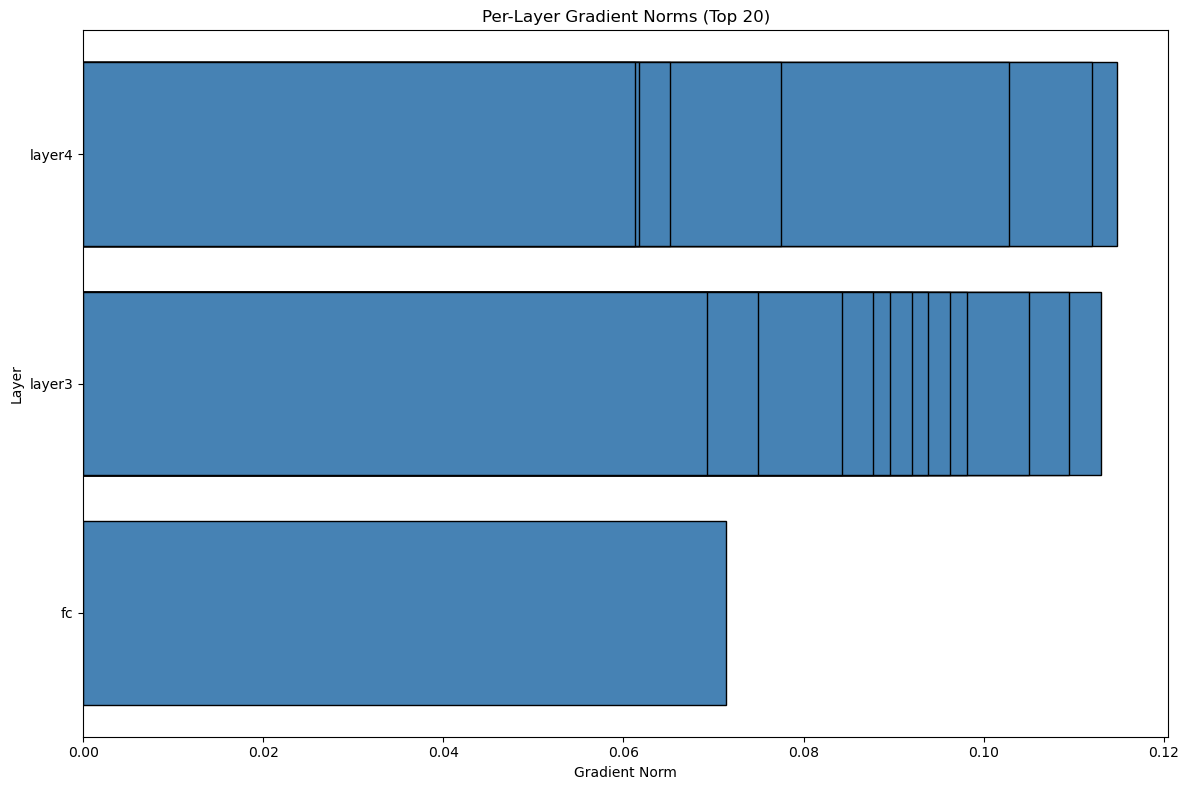

In [54]:
def visualize_gradient_norms(gradient_norms, top_n=None):
    # Sort layers by gradient norm in descending order
    sorted_gradient_norms = sorted(gradient_norms, key=lambda x: x[1], reverse=True)

    # Optionally show only the top N layers
    if top_n is not None:
        sorted_gradient_norms = sorted_gradient_norms[:top_n]

    layers, norms = zip(*sorted_gradient_norms)

    # Shorten layer names if too long
    short_layers = [layer.split('.')[0] for layer in layers]

    # Increase figure size for better spacing
    plt.figure(figsize=(12, 8))
    plt.barh(short_layers, norms, color='steelblue', edgecolor='black')
    plt.xlabel("Gradient Norm")
    plt.ylabel("Layer")
    plt.title(f"Per-Layer Gradient Norms {'(Top ' + str(top_n) + ')' if top_n else ''}")
    plt.gca().invert_yaxis()  # Show highest gradient norm at the top
    plt.tight_layout()
    plt.show()

# Example usage
visualize_gradient_norms(gradient_norms, top_n=20)  # Show only the top 20 layers


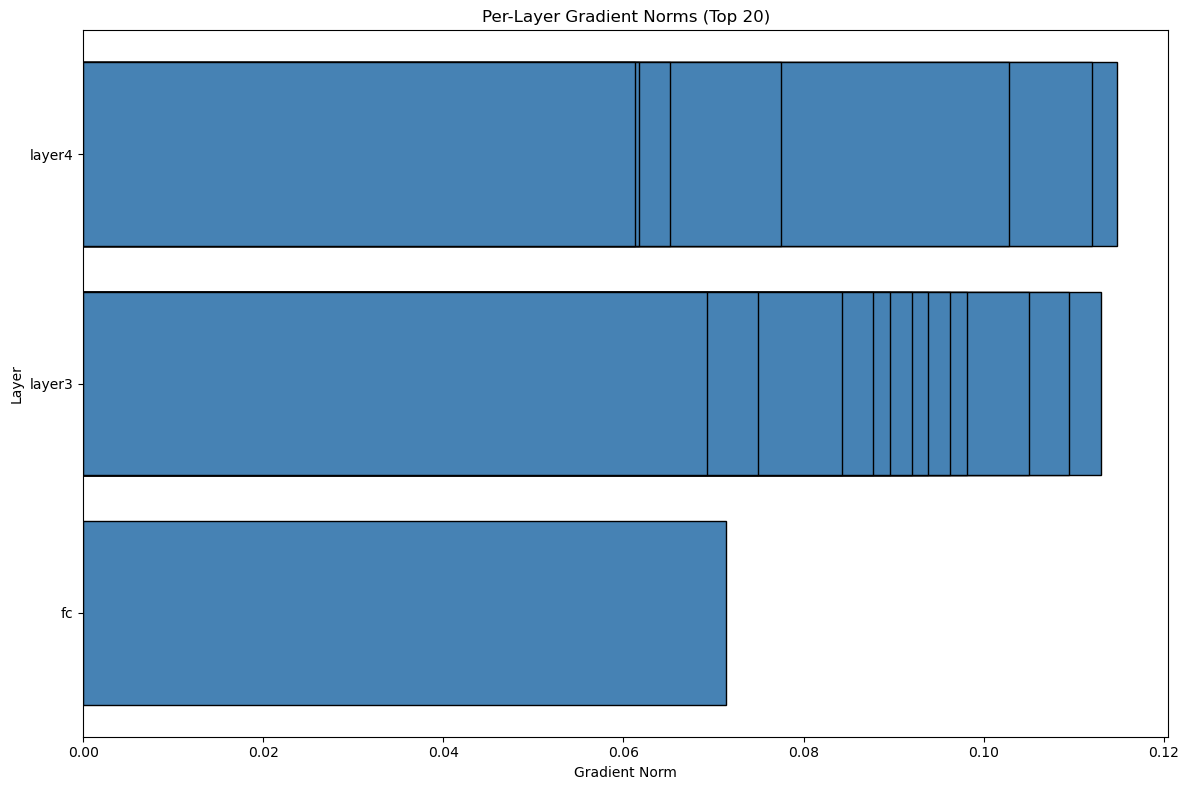

In [30]:
def visualize_gradient_norms(gradient_norms, top_n=None):
    # Sort layers by gradient norm in descending order
    sorted_gradient_norms = sorted(gradient_norms, key=lambda x: x[1], reverse=True)

    # Optionally show only the top N layers
    if top_n is not None:
        sorted_gradient_norms = sorted_gradient_norms[:top_n]

    layers, norms = zip(*sorted_gradient_norms)

    # Shorten layer names if too long
    short_layers = [layer.split('.')[0] for layer in layers]

    # Increase figure size for better spacing
    plt.figure(figsize=(12, 8))
    plt.barh(short_layers, norms, color='steelblue', edgecolor='black')
    plt.xlabel("Gradient Norm")
    plt.ylabel("Layer")
    plt.title(f"Per-Layer Gradient Norms {'(Top ' + str(top_n) + ')' if top_n else ''}")
    plt.gca().invert_yaxis()  # Show highest gradient norm at the top
    plt.tight_layout()
    plt.show()

# Example usage
visualize_gradient_norms(gradient_norms, top_n=20)  # Show only the top 20 layers


In [32]:
slice_processing_times = []  # Initialize the list to store processing times


In [35]:
import time

while not priority_queue.empty():
    start_time = time.time()  # Start timing
    priority, slice_key = priority_queue.get()
    slice_grad = slices_dict[slice_key]
    priority_log.append(priority)  # Log the priority
    elapsed_time = time.time() - start_time  # Calculate processing time
    slice_processing_times.append((priority, elapsed_time))  # Log the time
    print(f"Processed slice {slice_key} with priority {priority} in {elapsed_time:.4f} seconds")


Processed slice conv1.weight_slice_0 with priority 1 in 0.0000 seconds
Processed slice conv1.weight_slice_1 with priority 1 in 0.0000 seconds
Processed slice conv1.weight_slice_2 with priority 1 in 0.0000 seconds
Processed slice conv1.weight_slice_3 with priority 1 in 0.0000 seconds
Processed slice bn1.bias_slice_0 with priority 3 in 0.0000 seconds
Processed slice bn1.bias_slice_1 with priority 3 in 0.0000 seconds
Processed slice bn1.bias_slice_2 with priority 3 in 0.0000 seconds
Processed slice bn1.bias_slice_3 with priority 3 in 0.0000 seconds
Processed slice bn1.weight_slice_0 with priority 3 in 0.0000 seconds
Processed slice bn1.weight_slice_1 with priority 3 in 0.0000 seconds
Processed slice bn1.weight_slice_2 with priority 3 in 0.0000 seconds
Processed slice bn1.weight_slice_3 with priority 3 in 0.0000 seconds
Processed slice layer1.0.bn1.bias_slice_0 with priority 33 in 0.0000 seconds
Processed slice layer1.0.bn1.bias_slice_1 with priority 33 in 0.0000 seconds
Processed slice la

In [36]:
for layer_name, param in model.named_parameters():
    if param.grad is not None:
        slices = slice_parameters(param, num_slices=4)  # Slice gradients
        for i, slice_grad in enumerate(slices):
            slice_key = f"{layer_name}_slice_{i}"
            slices_dict[slice_key] = slice_grad
            priority_queue.put((priority_mapping[layer_name.split('.')[0]], slice_key))


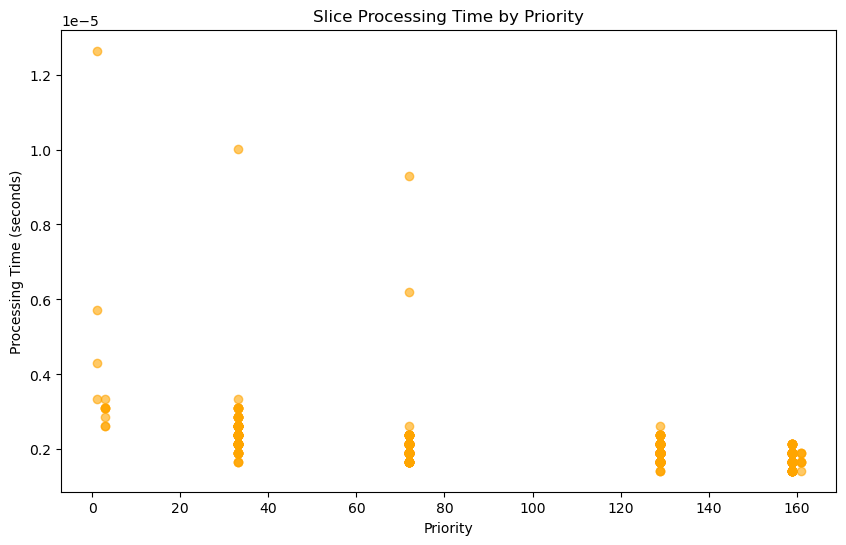

In [37]:
def visualize_processing_times(slice_processing_times):
    if len(slice_processing_times) == 0:
        print("No processing times to visualize.")
        return

    # Unpack priorities and times
    priorities, times = zip(*slice_processing_times)

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(priorities, times, alpha=0.6, color='orange')
    plt.xlabel("Priority")
    plt.ylabel("Processing Time (seconds)")
    plt.title("Slice Processing Time by Priority")
    plt.show()

# Example usage
visualize_processing_times(slice_processing_times)

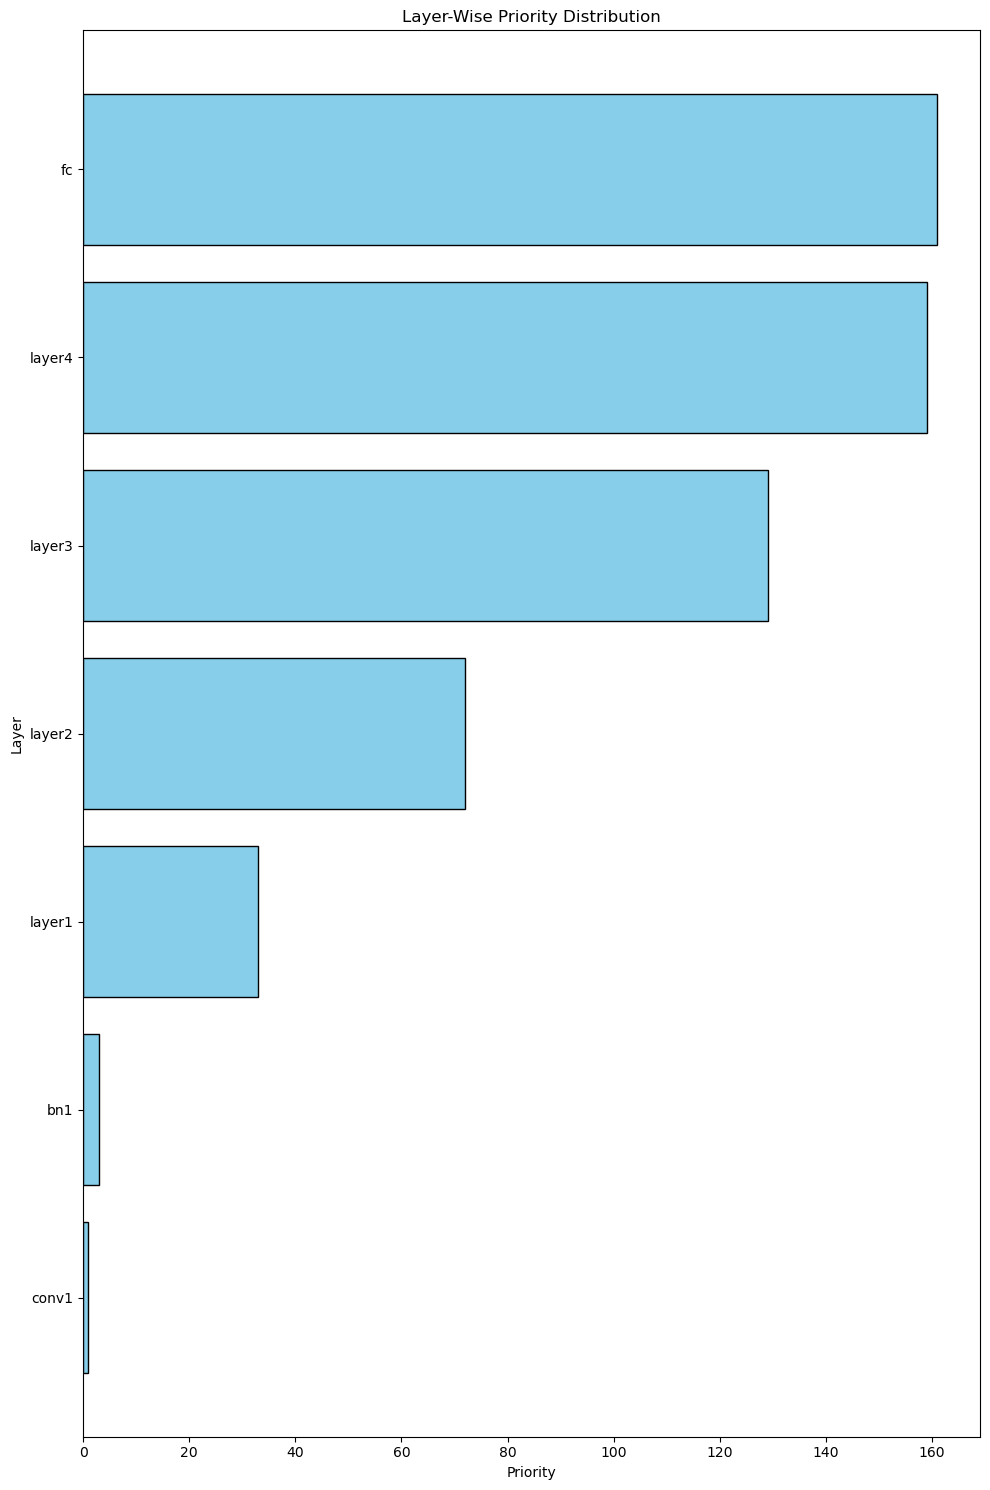

In [27]:
def visualize_layer_priorities(priority_mapping):
    # Sort priorities by value (descending)
    layers, priorities = zip(*sorted(priority_mapping.items(), key=lambda x: x[1], reverse=True))

    # Abbreviate long layer names
    short_layers = [layer.split('.')[0] for layer in layers]

    # Increase figure size and use horizontal bars
    plt.figure(figsize=(10, 15))
    plt.barh(short_layers, priorities, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel("Priority")
    plt.ylabel("Layer")
    plt.title("Layer-Wise Priority Distribution")
    plt.gca().invert_yaxis()  # Show highest priority at the top

    # Display plot
    plt.tight_layout()
    plt.show()

# Example usage
visualize_layer_priorities(priority_mapping)


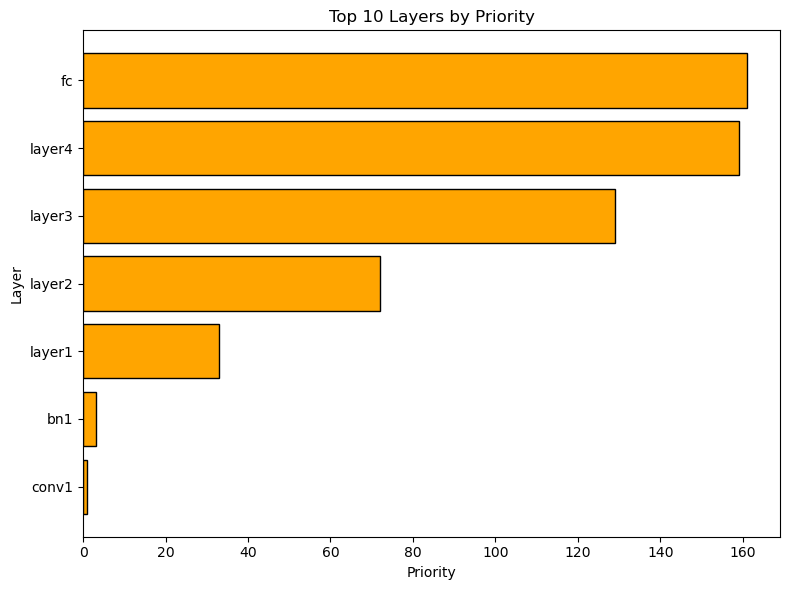

In [28]:
def visualize_top_layers(priority_mapping, top_n=10):
    # Sort priorities by value (descending) and take the top N layers
    sorted_mapping = sorted(priority_mapping.items(), key=lambda x: x[1], reverse=True)[:top_n]
    layers, priorities = zip(*sorted_mapping)

    plt.figure(figsize=(8, 6))
    plt.barh(layers, priorities, color='orange', edgecolor='black')
    plt.xlabel("Priority")
    plt.ylabel("Layer")
    plt.title(f"Top {top_n} Layers by Priority")
    plt.gca().invert_yaxis()  # Show highest priority at the top
    plt.tight_layout()
    plt.show()

# Example usage
visualize_top_layers(priority_mapping, top_n=10)


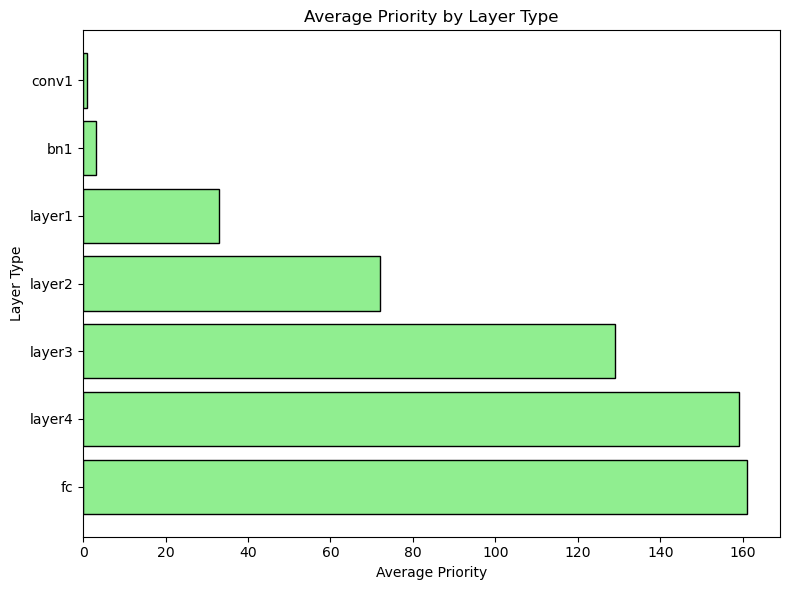

In [29]:
from collections import defaultdict

def visualize_priority_by_layer_type(priority_mapping):
    # Group priorities by layer type
    layer_type_priorities = defaultdict(list)
    for layer, priority in priority_mapping.items():
        layer_type = layer.split('.')[0]
        layer_type_priorities[layer_type].append(priority)

    # Aggregate priorities (mean priority per layer type)
    layer_types = list(layer_type_priorities.keys())
    avg_priorities = [sum(priorities) / len(priorities) for priorities in layer_type_priorities.values()]

    plt.figure(figsize=(8, 6))
    plt.barh(layer_types, avg_priorities, color='lightgreen', edgecolor='black')
    plt.xlabel("Average Priority")
    plt.ylabel("Layer Type")
    plt.title("Average Priority by Layer Type")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Example usage
visualize_priority_by_layer_type(priority_mapping)


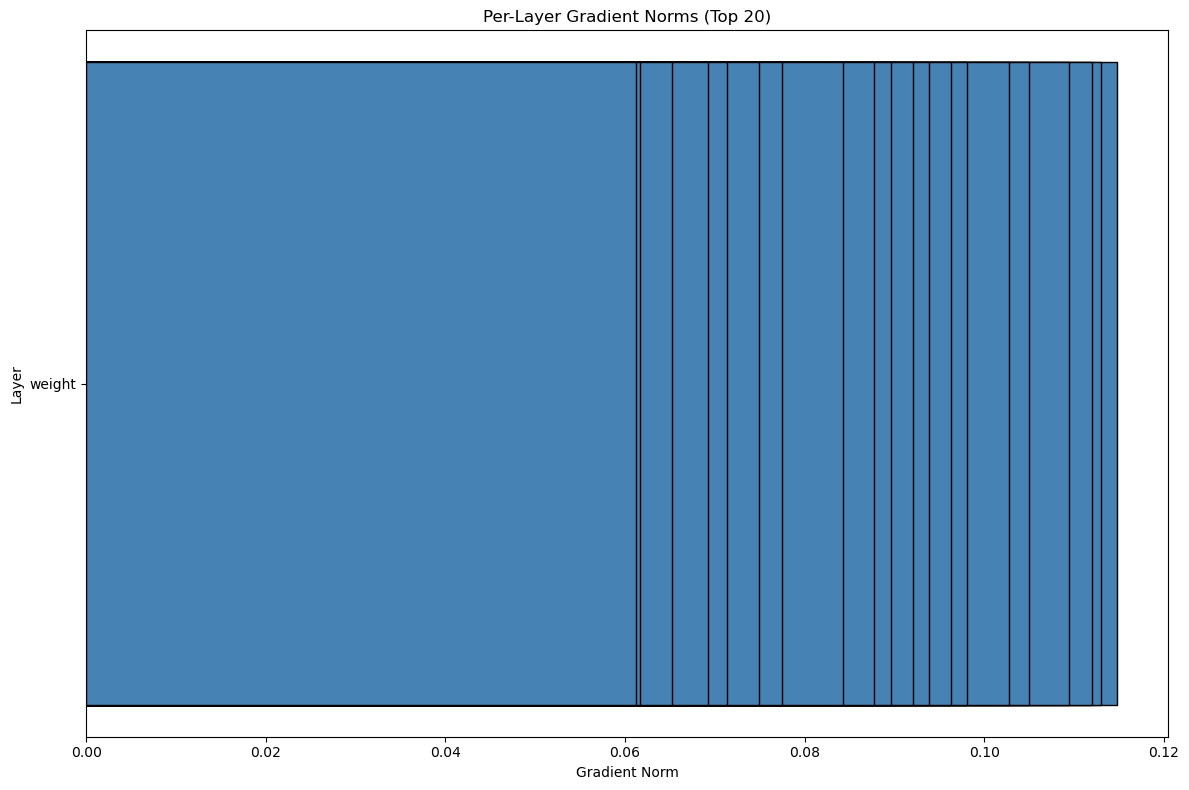

In [31]:
def visualize_gradient_norms(gradient_norms, top_n=None):
    # Sort layers by gradient norm in descending order
    sorted_gradient_norms = sorted(gradient_norms, key=lambda x: x[1], reverse=True)

    # Optionally show only the top N layers
    if top_n is not None:
        sorted_gradient_norms = sorted_gradient_norms[:top_n]

    layers, norms = zip(*sorted_gradient_norms)

    # Shorten layer names if too long
    short_layers = [layer.split('.')[-1] for layer in layers]  # Use last part of the name

    # Increase figure size for better spacing
    plt.figure(figsize=(12, 8))
    plt.barh(short_layers, norms, color='steelblue', edgecolor='black')
    plt.xlabel("Gradient Norm")
    plt.ylabel("Layer")
    plt.title(f"Per-Layer Gradient Norms {'(Top ' + str(top_n) + ')' if top_n else ''}")
    plt.gca().invert_yaxis()  # Show highest gradient norm at the top
    plt.tight_layout()
    plt.show()

# Example usage
visualize_gradient_norms(gradient_norms, top_n=20)


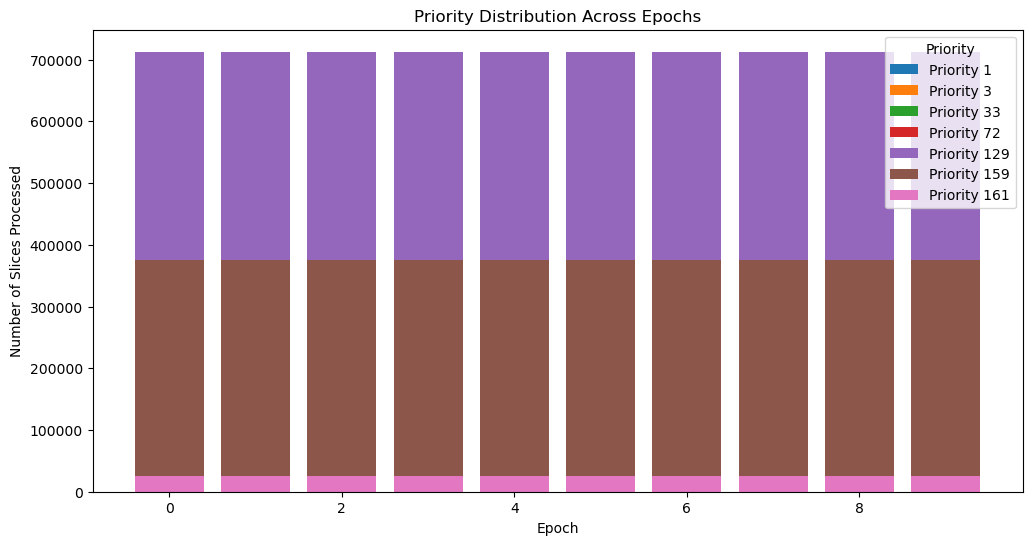

In [43]:
from collections import Counter
import matplotlib.pyplot as plt

def visualize_priority_distribution(priority_log, num_epochs):
    epoch_wise_priorities = [priority_log[i::num_epochs] for i in range(num_epochs)]
    
    # Count priorities for each epoch
    epoch_priority_counts = [Counter(epoch) for epoch in epoch_wise_priorities]
    
    # Prepare data for stacked bar chart
    priorities = sorted(set(priority_log))
    counts = [[epoch_count[priority] for priority in priorities] for epoch_count in epoch_priority_counts]

    # Plot stacked bar chart
    plt.figure(figsize=(12, 6))
    for i, priority in enumerate(priorities):
        plt.bar(range(num_epochs), [count[i] for count in counts], label=f"Priority {priority}")

    plt.xlabel("Epoch")
    plt.ylabel("Number of Slices Processed")
    plt.title("Priority Distribution Across Epochs")
    plt.legend(title="Priority")
    plt.show()

# Example usage
visualize_priority_distribution(priority_log, num_epochs=10)


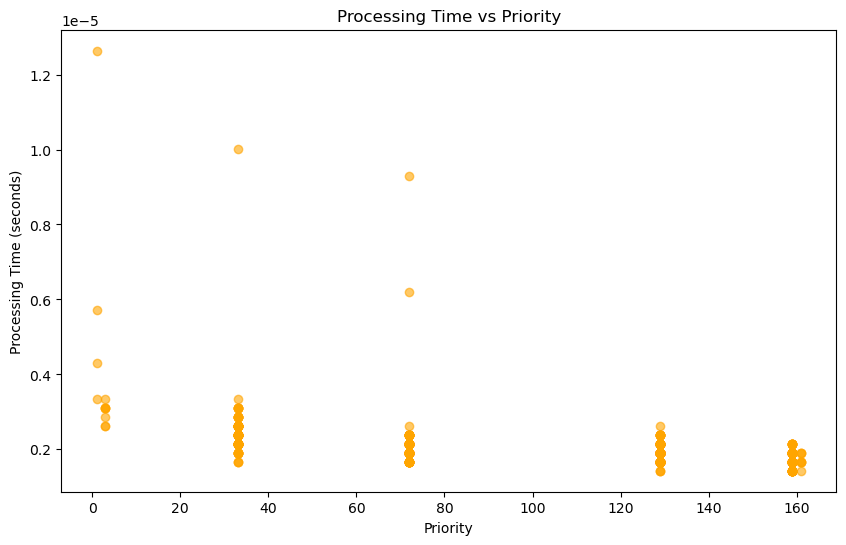

In [45]:
def visualize_processing_time_vs_priority(slice_processing_times):
    if len(slice_processing_times) == 0:
        print("No processing times to visualize.")
        return

    priorities, times = zip(*slice_processing_times)

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(priorities, times, alpha=0.6, color='orange')
    plt.xlabel("Priority")
    plt.ylabel("Processing Time (seconds)")
    plt.title("Processing Time vs Priority")
    plt.show()

# Example usage
visualize_processing_time_vs_priority(slice_processing_times)


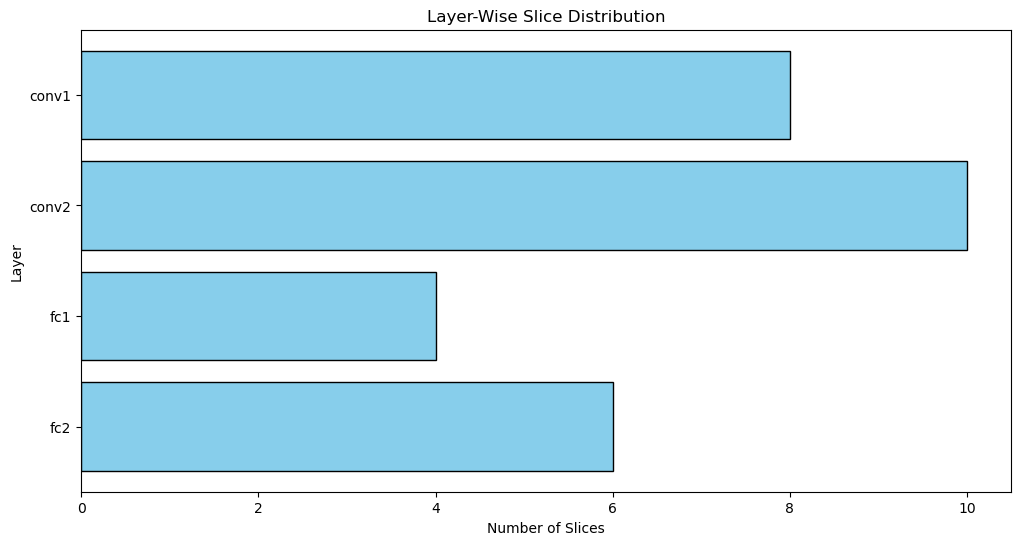

In [46]:
def visualize_layer_slice_distribution(slice_distribution):
    layers, num_slices = zip(*slice_distribution.items())

    plt.figure(figsize=(12, 6))
    plt.barh(layers, num_slices, color='skyblue', edgecolor='black')
    plt.xlabel("Number of Slices")
    plt.ylabel("Layer")
    plt.title("Layer-Wise Slice Distribution")
    plt.gca().invert_yaxis()
    plt.show()

# Example data and usage
slice_distribution = {'conv1': 8, 'conv2': 10, 'fc1': 4, 'fc2': 6}
visualize_layer_slice_distribution(slice_distribution)


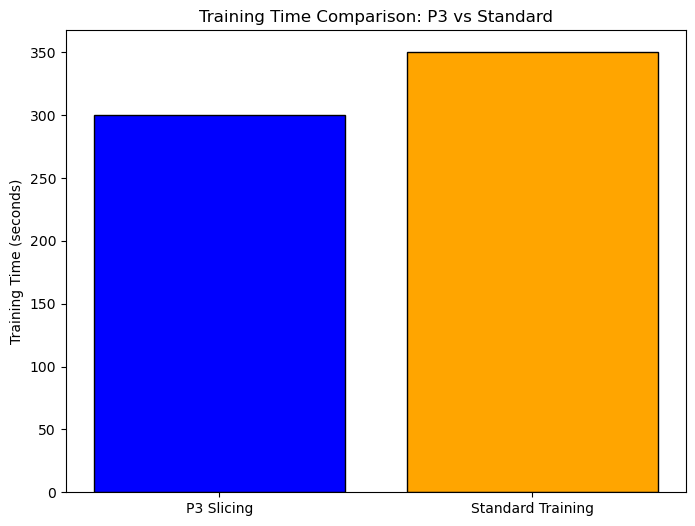

In [47]:
def visualize_training_time(p3_time, standard_time):
    plt.figure(figsize=(8, 6))
    plt.bar(["P3 Slicing", "Standard Training"], [p3_time, standard_time], color=['blue', 'orange'], edgecolor='black')
    plt.ylabel("Training Time (seconds)")
    plt.title("Training Time Comparison: P3 vs Standard")
    plt.show()

# Example usage
visualize_training_time(p3_time=300, standard_time=350)


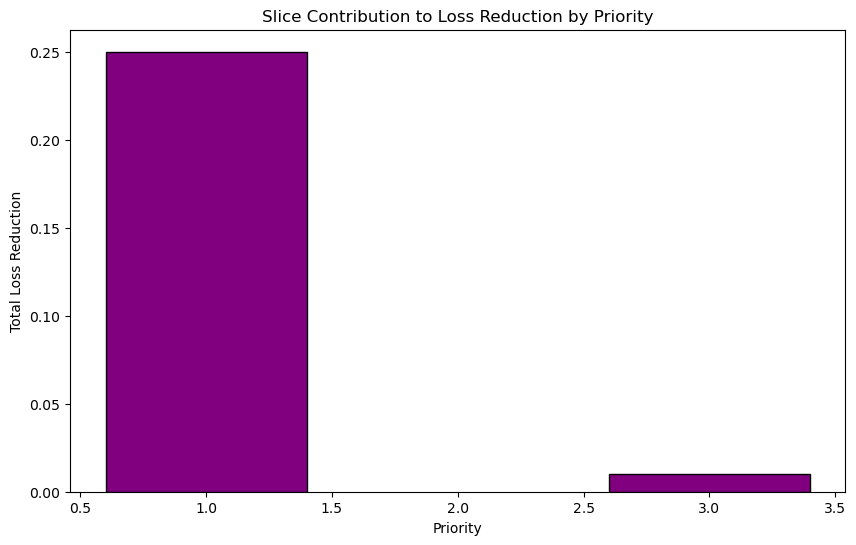

In [49]:
def visualize_slice_contribution(priority_log, loss_reduction_log):
    # Aggregate loss reduction by priority
    priority_loss_reduction = {}
    for priority, loss_reduction in zip(priority_log, loss_reduction_log):
        if priority not in priority_loss_reduction:
            priority_loss_reduction[priority] = 0
        priority_loss_reduction[priority] += loss_reduction

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(priority_loss_reduction.keys(), priority_loss_reduction.values(), color='purple', edgecolor='black')
    plt.xlabel("Priority")
    plt.ylabel("Total Loss Reduction")
    plt.title("Slice Contribution to Loss Reduction by Priority")
    plt.show()

# Example usage
loss_reduction_log = [0.1, 0.08, 0.05, 0.02, 0.01]  # Example loss reductions for priorities
visualize_slice_contribution(priority_log, loss_reduction_log)


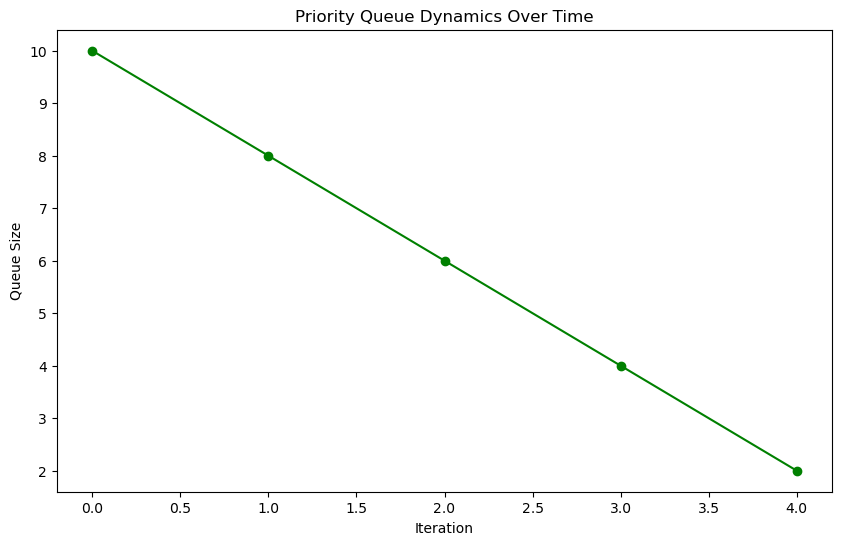

In [50]:
def visualize_queue_dynamics(priority_queue_sizes):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(priority_queue_sizes)), priority_queue_sizes, marker='o', linestyle='-', color='green')
    plt.xlabel("Iteration")
    plt.ylabel("Queue Size")
    plt.title("Priority Queue Dynamics Over Time")
    plt.show()

# Example usage
priority_queue_sizes = [10, 8, 6, 4, 2]  # Example queue sizes logged during training
visualize_queue_dynamics(priority_queue_sizes)
